In [91]:
import sklearn
import numpy as np
import os

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Clustering

## Classification _vs_ Clustering

In [92]:
from sklearn.datasets import load_iris

In [93]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

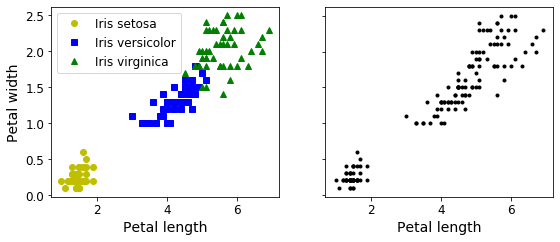

In [94]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

Дане зображення ілюструє різницю даних у задачах класифікації та кластеризації: у першому випадку відгуки є відомими (для навчальної вибірки), а у другому - ні.

Застосуємо Gaussian mixture model. Вона розбиває дані на кластери досить близько до значення класів.

In [95]:
from sklearn.mixture import GaussianMixture

In [96]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([1, 2, 0])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

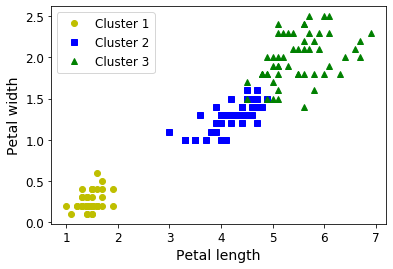

In [97]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [98]:
np.sum(y_pred==y)

145

In [99]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

## K-Means

Почнемо з генерації датасету:

In [100]:
from sklearn.datasets import make_blobs

In [101]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [102]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Візуалізуємо:

In [103]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

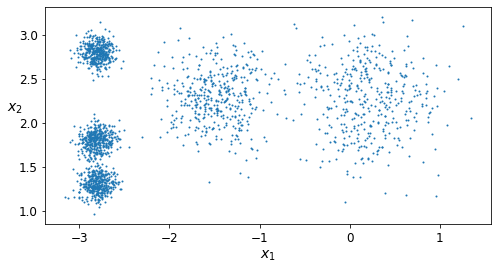

In [104]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

### Натренуємо K-Means

In [105]:
from sklearn.cluster import KMeans

In [106]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Кожний елемент був асоційованим з одним з 5 кластерів:

In [107]:
y_pred

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

kmeans.labels_ містить id кластерів, асоційованих з елементами тренувальної вибірки:

In [108]:
y_pred is kmeans.labels_

True

Центроїди кластерів:

In [109]:
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

Звісно, ми також можемо асоціювати нові дані з існуючими кластерами шляхом знаходження найближчого центроїда:

In [110]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

### Межі рішень

Межі рішень утворюють _діаграму Вороного_:

In [111]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

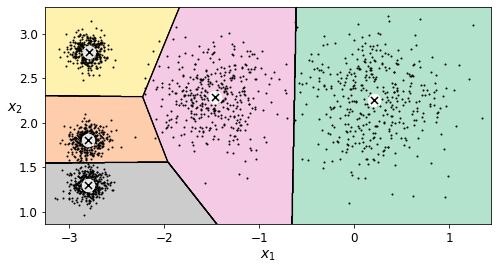

In [112]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

### Hard Clustering _vs_ Soft Clustering

Замість присвоєння кластера елементу вибірки, ми могли б порівняти відстані до відповідних центрів, і таким чином отримати т.з. м'яку кластеризацію. Для цього використаємо функцію `transform()`:

In [113]:
kmeans.transform(X_new)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

Дійсно, це відстань до центроїдів:

In [114]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

### Вплив ініціалізації на K-Means

In [115]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

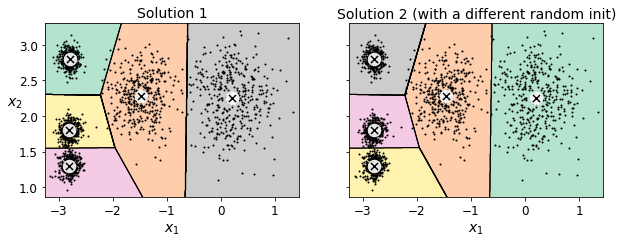

In [116]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

### Інерція

Для порівняння розбиттів на кластери введемо метрику, що називається інерція: суму відстаней від елементів до центроїдів відповідних кластерів:

In [117]:
kmeans.inertia_

211.5985372581684

Дійсно:

In [118]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

Метож `score()` повертає від'ємну інерцію:

In [119]:
kmeans.score(X)

-211.59853725816856

### Оптимальна кількісьб кластерів

Розглянемо тепер кількість кластерів, відмінну від 5

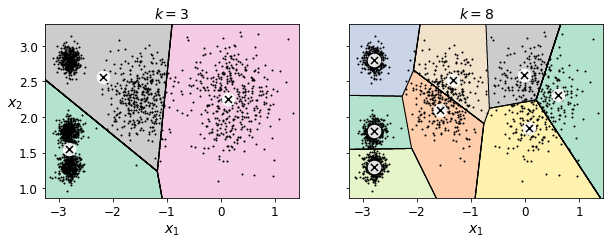

In [120]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

Обчисливо відповідну інерцію

In [121]:
kmeans_k3.inertia_

653.2167190021553

In [122]:
kmeans_k8.inertia_

118.41753416184663

Інерція лише спадатиме зі зростанням кільксті кластрів, і не може прямо слугувати для визначення оптимальної кількості кластерів. Натомість, зобразимо графік залежності інерції від кількості кластерів:

In [123]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

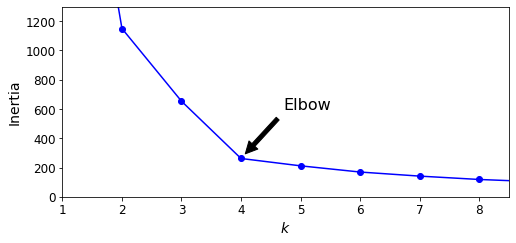

In [125]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

Як ми бачимо, цей графік має "лікоть" при $k=4$, що означає, що при подальшому збільшенні кількості кластрів інерція починає спадати повільно. Можемо припустити, що $k=4$ є хорошим наближення оптимальної кількості кластерів.

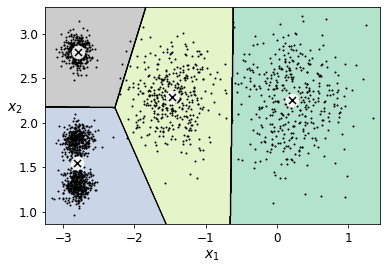

In [126]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Інша метрика - це _silhouette score_, що визначається як середнє знання _silhouette coefficient_ у датасетів. В свою чергу, silhouette coefficient елемента дорівнює $(b - a)/\max(a, b)$ де $a$ є середньою відстанню від елемента до елементів свого кластера, а $b$ є is середньою відстанню від елемента до елементів найближчого сусіднього кластера. Значення silhouette coefficient варіюється від -1 до +1.

Зобразимо silhouette score як функцію від $k$:

In [127]:
from sklearn.metrics import silhouette_score

In [128]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [129]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

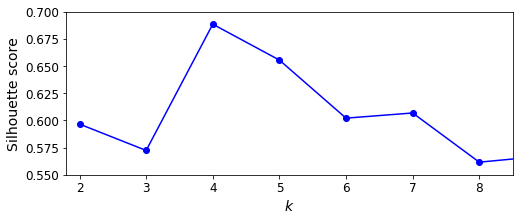

In [131]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

Дана діаграма вказує, що і $k=4$, і $k=5$ є хорошим вибором.

###  _Silhouette diagram_

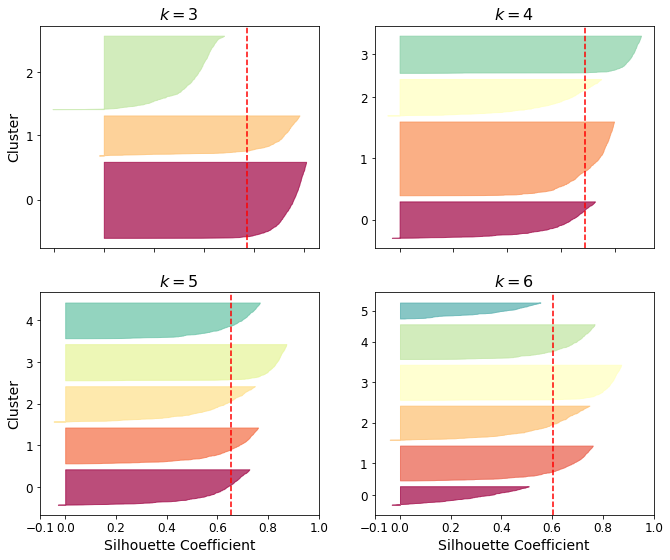

In [132]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
    
plt.show()

### K-Means та кластери "неправильної" форми

K-Means погано справляється з близько розташованими кластерами неправильної форми, або різних розмірів

In [133]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

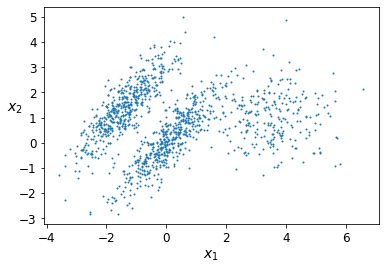

In [134]:
plot_clusters(X)

In [135]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

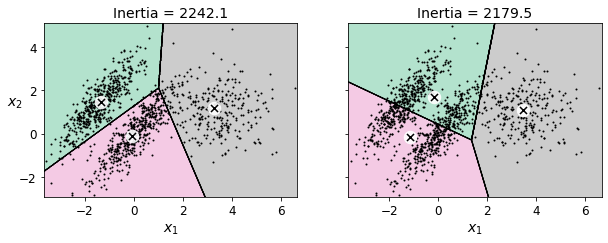

In [136]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

### Кластеризація для сегментації зображень

In [137]:
import urllib
filename = "ladybug.png"

url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/images/unsupervised_learning/ladybug.png"
urllib.request.urlretrieve(url,  filename)

('ladybug.png', <http.client.HTTPMessage at 0x7fc638c03cc0>)

In [138]:
from matplotlib.image import imread
image = imread(filename)
image.shape

(533, 800, 3)

In [139]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [140]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

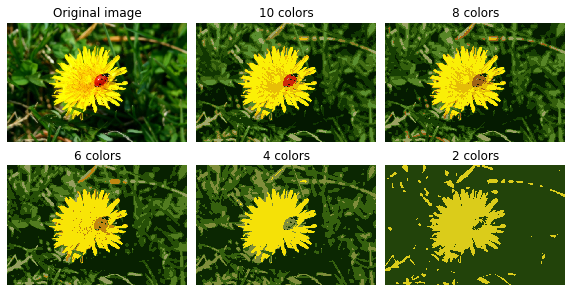

In [141]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')
plt.show()

# Gaussian Mixtures

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Натренуємо GMM:

In [156]:
from sklearn.mixture import GaussianMixture

In [157]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Параметри моделі:

In [158]:
gm.weights_

array([0.48399555, 0.13202522, 0.38397923])

In [159]:
gm.means_

array([[0.05578103, 0.18499708, 0.00615465],
       [0.97255737, 0.89005184, 0.02121926],
       [0.32016352, 0.42949557, 0.12274126]])

In [160]:
gm.covariances_

array([[[2.92877458e-03, 4.54759059e-03, 1.35023932e-04],
        [4.54759059e-03, 1.04642069e-02, 1.97726477e-04],
        [1.35023932e-04, 1.97726477e-04, 5.66702202e-05]],

       [[1.51202252e-03, 1.97670126e-03, 3.12269926e-05],
        [1.97670126e-03, 1.04995441e-02, 4.27776252e-04],
        [3.12269926e-05, 4.27776252e-04, 7.70607997e-04]],

       [[3.54973077e-02, 1.87271724e-02, 1.23999422e-02],
        [1.87271724e-02, 2.42540589e-02, 1.11774351e-02],
        [1.23999422e-02, 1.11774351e-02, 1.40810458e-02]]])

Чи алгоритм збігся?

In [161]:
gm.converged_

True

За скільки ітерацій?

In [162]:
gm.n_iter_

13

Знайдемо асоціацію елементів з розподілами з суміші (що можуть розглядатися як кластери):

In [163]:
gm.predict(X)

array([0, 0, 0, ..., 0, 0, 0])

In [164]:
gm.predict_proba(X)

array([[9.78014428e-001, 3.56626109e-114, 2.19855719e-002],
       [9.77837460e-001, 3.38164071e-115, 2.21625403e-002],
       [9.66868353e-001, 3.53876299e-115, 3.31316467e-002],
       ...,
       [9.93113193e-001, 2.27242705e-135, 6.88680741e-003],
       [9.92960765e-001, 1.22373915e-140, 7.03923521e-003],
       [9.92759934e-001, 8.73014576e-144, 7.24006625e-003]])

Можемо синтезувати нові елементи згідно з отриманим розподілом:

In [165]:
X_new, y_new = gm.sample(6)
X_new

array([[ 0.06367341,  0.10092977,  0.00532835],
       [ 0.10683751,  0.18987468,  0.01436431],
       [ 0.09218562,  0.22616976,  0.00465085],
       [ 0.98258725,  0.93991518, -0.02948431],
       [ 0.9873945 ,  1.0721021 ,  0.00451941],
       [ 0.20551791,  0.50891836,  0.02887409]])

In [166]:
y_new

array([0, 0, 0, 1, 1, 2])

Можна також отримати логарифм фунції щільності за допомогою функції `score_samples()` :

In [167]:
gm.score_samples(X)

array([4.18216046, 4.12977135, 3.79577613, ..., 6.23721735, 6.00157555,
       5.81810221])

Зобразимо межі рішень та контури функції щільності:

In [168]:
from matplotlib.colors import LogNorm

resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [169]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.show()

ValueError: Expected the input data X have 3 features, but got 2 features

<Figure size 576x288 with 0 Axes>

Ми можемо накладати умови на матриці коваріації за допомогою параметру `covariance_type`:

In [170]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

KeyboardInterrupt: 

In [ ]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


In [ ]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
plt.show()

In [ ]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Виявлення аномалій за допомогою GMM

GMM можна використати для виявлення аномалій: елементи у областях малої щільності можуть вважатися аномальними. Наприклад, знайдемо поріг функції щільності такий, що 4% елементів знаходять за порогом:

In [ ]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

In [ ]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

# Завдання

*Завдання 1: Завантажте MNIST. Розбийте його на навчальну, валідаційну та тренувальну вибірку. Застосуйте PCA для зменшення розмірності.*

*Завдання 2: Кластеризуйте датасет, використовуючи K-Means. Знайдіть оптимальну кількість кластерів*

*Завдання 3: Натренуйте GMM.*

*Завдання 4: Синтезуйте нові елементи вибірки, використовуючи GMM. Візуалізуйте їх.*